In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
dataset = pd.read_csv('D:/C_Drive_Desktop/Data_Analytics_For_Business_Decision_Making/2nd_Semester/2nd_Semester/2206_Capstone_Project/Final_Dataset/Obesity_data_Smote_wo_BMI.csv')
dataset.head()

,Age,Gender,Height,Weight,PhysicalActivityLevel,ObesityCategory
0,56,0,173.58,71.98,4,0
1,69,0,164.13,89.96,2,1
2,46,1,168.07,72.93,4,0
3,32,0,168.46,84.89,3,0
4,60,0,183.57,69.04,3,0


In [3]:
#Key Attributes
dataset.describe()

,Age,Gender,Height,Weight,PhysicalActivityLevel,ObesityCategory
count,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000
mean,49.818294,0.378863,167.240520,77.809647,2.405439,0.500000
std,18.121090,0.485254,10.147260,15.834080,1.045659,0.500155
min,18.000000,0.000000,136.120000,26.070000,1.000000,0.000000
25%,35.000000,0.000000,160.715341,67.842500,2.000000,0.000000
50%,50.000000,0.000000,166.780440,79.097140,2.000000,0.500000
75%,66.000000,1.000000,173.772500,89.864469,3.000000,1.000000
max,79.000000,1.000000,201.420000,118.910000,4.000000,1.000000


Class Split
0    809
1    809
Name: ObesityCategory, dtype: int64


Text(0, 0.5, 'Count')

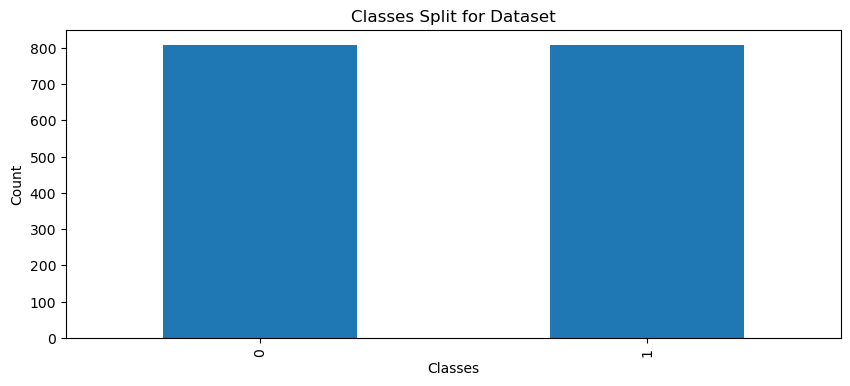

In [4]:
#Class Balance
print('Class Split')
print(dataset['ObesityCategory'].value_counts())
dataset['ObesityCategory'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [5]:
#Create x and y variables
x = dataset.drop('ObesityCategory', axis=1).to_numpy()
y = dataset['ObesityCategory'].to_numpy()

#Create Train and Test Dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_rdf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=100))])
pipeline.insert(0,pipe_rdf)

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', DecisionTreeClassifier(random_state=100))])
pipeline.insert(1,pipe_dt)

# Set grid search params 

modelpara =[]

param_gridrdf = {
            'clf__criterion':['gini','entropy'],
            'clf__n_estimators': [100,150,200],
            'clf__bootstrap': [True, False]}
modelpara.insert(0,param_gridrdf)

max_depth = range(1,100)
param_griddt = {'clf__criterion':['gini','entropy'],
                'clf__max_depth':max_depth}
modelpara.insert(1,param_griddt)

In [7]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Decision Tree - Learning Curve


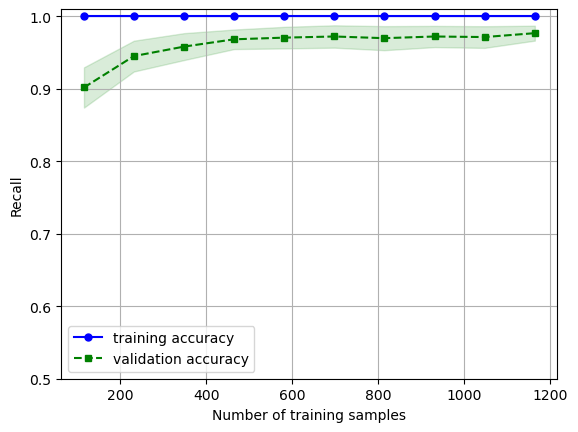


Random Forest - Learning Curve


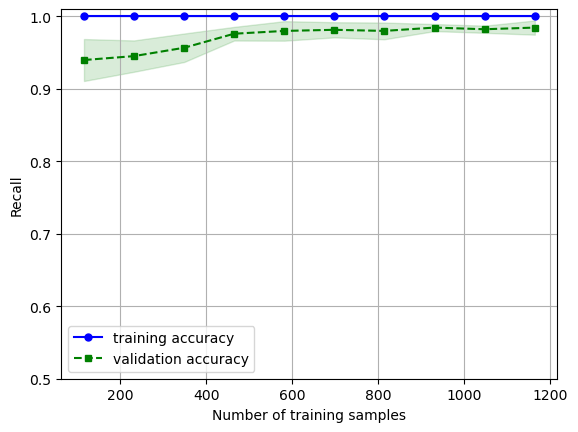

In [8]:
#Plot Learning Curve
print('Decision Tree - Learning Curve')
plot_learning_curves(pipe_dt)
print('\nRandom Forest - Learning Curve')
plot_learning_curves(pipe_rdf)

Model Evaluation - Recall
Decision Tree 0.98 +/- 0.01
Random Forest 0.98 +/- 0.01




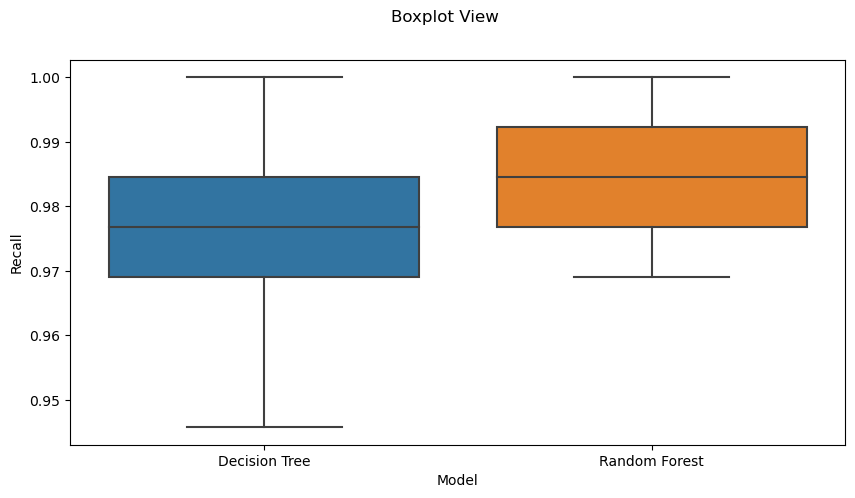

In [9]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Decision Tree',pipe_dt))
models.append(('Random Forest',pipe_rdf))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

#Boxpot View
fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [10]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params,cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\n')
    
    #Feature Importance - optimized
    print('Feature Importances')
    for name, score in zip(list(dataset),gs_clf.best_estimator_.named_steps['clf'].feature_importances_):
        print(name, round(score,2))
    
    #Output Validation Statistics
    target_names=['0','1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names))     

In [11]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: RandomForestClassifier(random_state=100)


Feature Importances
Age 0.04
Gender 0.02
Height 0.31
Weight 0.61
PhysicalActivityLevel 0.02

Best Parameters: {'clf__bootstrap': False, 'clf__criterion': 'gini', 'clf__n_estimators': 100}

 [[158   4]
 [  0 162]]

               precision    recall  f1-score   support

           0       1.00      0.98      0.99       162
           1       0.98      1.00      0.99       162

    accuracy                           0.99       324
   macro avg       0.99      0.99      0.99       324
weighted avg       0.99      0.99      0.99       324


Optimized Model

Model Name: DecisionTreeClassifier(random_state=100)


Feature Importances
Age 0.0
Gender 0.0
Height 0.36
Weight 0.63
PhysicalActivityLevel 0.0

Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 10}

 [[159   3]
 [  5 157]]

               precision    recall  f1-score   support

           0       0.97      0.98      0.98       162
           1     